# Step 0: Setup The Python Virtual Environment
- Create the environment: ```python3 -m venv .venv```
- Activate it: ```source .venv/bin/activate```
- Install pacages: ```pip install {PACKAGE}```
- Deactivate it: ```deactivate```
- Save packages: ```pip freeze > requirements.txt```
- Recreate environment: ```pip install -r requirements.txt```

In [1]:
# Install relevant packages, execute as shell
!pip install -Uqq fastai duckduckgo_search
!pip install --upgrade certifi

In [2]:
# Import packages for the notebook

# Third party packages
from fastdownload import download_url
from duckduckgo_search import DDGS
from fastai.vision.all import *
from fastcore.all import *

# Native packages
from time import sleep

# Step 1: Build the Training Data Set

In [3]:
# GOAL: Define a function to search images on duckduckgo

# Define the function
def search_images(term, max_images=30):

    # Log the search term
    print(f"Searching for '{term}'...")

    # Retrieve results as links
    results = DDGS().images(
        keywords=term,
        max_results=max_images,
    )

    # Return an enhanced list of urls
    return L(results).itemgot("image")

Searching for 'bird photos'...


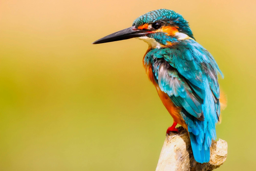

In [4]:
# GOAL: Validate that we are pulling pictures of birds for training our ML algorithm

# Retrieve URLs for images of bird photos
bird_photo_urls = search_images(
    "bird photos",
    max_images=1
    )

# Set the destination for an example image
bird_image_destination = "bird.jpg"

# Download the example bird photo
download_url(
    bird_photo_urls[0],
    bird_image_destination,
    show_progress=False
    )

# Render the image so we can validate our method for pulling training data
bird_image = Image.open(bird_image_destination)
bird_image.to_thumb(256,256)


Searching for 'forest photos'...


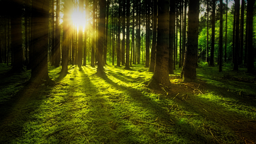

In [5]:
# GOAL: Validate that we are pulling pictures of forests for training our ML algorithm

# Retrieve URLs for images of forest photos
forest_photo_urls = search_images(
    "forest photos",
    max_images=1
    )

# Set the destination for an example image
forest_image_destination = "forest.jpg"

# Download the example forest photo
download_url(
    forest_photo_urls[0],
    forest_image_destination,
    show_progress=False
    )

# Render the image so we can validate our method for pulling training data
forest_image = Image.open(forest_image_destination)
forest_image.to_thumb(256,256)

In [6]:
# GOAL: Expand our set of example images

# Define searches for birds on forests
searches = [
    "forest",
    "bird"
    ]

# Define the folder to put our results in
path = Path('bird_or_not')

# Enumerate through our searches
for search in searches:

    # Define the destination folder to write the results
    destination_folder = (path/search)
    destination_folder.mkdir(exist_ok=True, parents=True)

    # Download the images
    download_images(destination_folder, urls=search_images(f'{search} photo'))
    sleep(10) # Pause between searches to avoid over-loading server

    download_images(destination_folder, urls=search_images(f'{search} sun photo'))
    sleep(10) # Pause between searches to avoid over-loading server

    download_images(destination_folder, urls=search_images(f'{search} shade photo'))
    sleep(10) # Pause between searches to avoid over-loading server

    resize_images(path/search, max_size=400, dest=path/search)

Searching for 'forest photo'...
Searching for 'forest sun photo'...
Searching for 'forest shade photo'...
Searching for 'bird photo'...
Searching for 'bird sun photo'...
Searching for 'bird shade photo'...


In [7]:
# GOAL: Remove files that did not download correctly

# Identify failed images
failed = verify_images(get_image_files(path))

# Remove failed images
failed.map(Path.unlink)

# Log the number removed
len(failed)

7

# Step 2: Train the Model

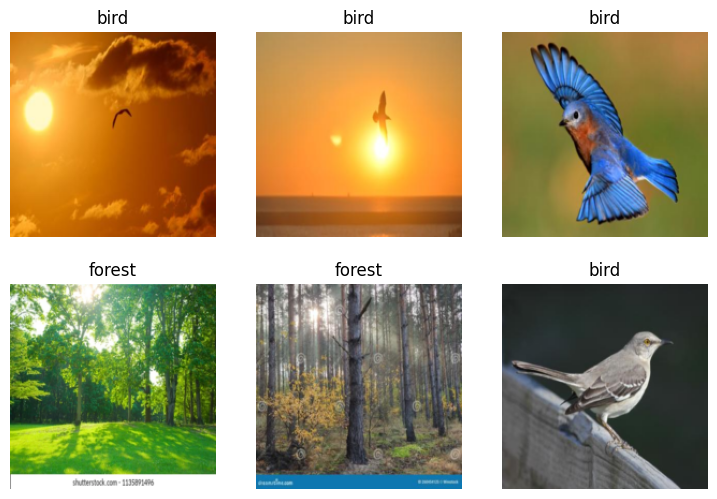

In [8]:
# GOAL: Prepare our dataset for training our model

# Using FastAI's datablock, setup our training and validation sets
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Define the type of input/output data e.g. we input images and output categories
    get_items=get_image_files, # Pass a function as the argument to get the training data we need
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Set aside 20% of our data for validation of the model
    get_y=parent_label, # Pass a function as the argument to tell the model what label to use for each image
    item_tfms=[Resize(192, method='squish')] # Resize all images to be the same for the training algorithm
).dataloaders(path, bs=32) # Pass the images to train

# View the dataset
dls.show_batch(max_n=6)

In [9]:
# GOAL: Train the model

# Train the model
learn = vision_learner(
    dls,
    resnet18, # Resnet18 will be fine
    metrics=error_rate
    )

# Adjust the pretrained weights for our use case
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/afrist/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.694371,0.032897,0.000000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.084666,0.004786,0.000000,00:03
1,0.057004,0.000477,0.000000,00:02
2,0.035970,0.000336,0.000000,00:02
